In [1]:
import os
import re
import sys

import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics as skmetrics
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import fontManager
from IPython.display import display
from ipywidgets import interact, FloatSlider
from umap import UMAP
import ipynbname
from endaaman.ml import fix_global_seed

project_root = os.path.abspath(os.path.join(os.path.dirname(ipynbname.path()), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(project_root)
print('now working', project_root)

DPI = 600

sns.set_theme(style="ticks", palette="tab10")
# sns.set_theme(style="white")
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size'] = 10  
plt.rcParams['axes.labelsize'] = 12  
plt.rcParams['axes.titlesize'] = 14  
plt.rcParams['xtick.labelsize'] = 10  
plt.rcParams['ytick.labelsize'] = 10 
plt.rcParams['figure.dpi'] = DPI

os.makedirs('out/figs', exist_ok=True)

fix_global_seed()

# print(f"デフォルトのフォント: {plt.rcParams['font.sans-serif']}")
# print(', '.join(sorted(list(set([font.name for font in fontManager.ttflist if not font.name.startswith('Noto')])))))

デフォルトのフォント: ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']


## Table2: Cross Validation

In [35]:
mm = [
    'Accuracy', 
    'Accuracy(Patch)', 
    'F1 score', 
    'Precision', 
    'Recall', 
]

def dump_to_table(target:Literal['cv', 'ebrains'], coarse=False, result_limit=100):
    r = None
    error_type = 'ci'
    grains = 'coarse' if coarse else 'fine'
    P = f'out/figs/table2_{grains}_{target}.xlsx'
    with pd.ExcelWriter(P) as w:
        for limit in [10, 25, 100, 500]:
            df = pd.read_excel(f'out/figs/results_{grains}_{target}.xlsx', sheet_name=f'{limit}', index_col=0)
            data = []
            labels = df['label'].unique()
            for l in labels:
                vvv = df[df['label'] == l]
                ss = {}
                for m in mm:
                    vv = vvv[m].values
                    mean = np.mean(vv)
                    if error_type == 'ci':
                        ci = stats.t.interval(confidence=0.95, df=len(vv)-1, loc=mean, scale=stats.sem(vv))
                        error = (ci[1] - ci[0])/2
                    else:
                        error = stats.sem(vv)                    
                    s = '{:.3f} ± {:.3f}'.format(mean, error)
                    ss[m] = s
                data.append(ss)
            df2 = pd.DataFrame(data, index=labels)
            df2.to_excel(w, sheet_name=f'{limit}')
            w.sheets[f'{limit}'].set_column('A:A', 30)
            w.sheets[f'{limit}'].set_column('B:Z', 12)
            if limit == result_limit:
                r = df2
    print(f'wrote {P}')
    return r 

In [36]:
dump_to_table('cv', False, 500)

wrote out/figs/table2_fine_cv.xlsx


,Accuracy,Accuracy(Patch),F1 score,Precision,Recall
Prov-GigaPath(LP),0.949 ± 0.040,0.931 ± 0.024,0.881 ± 0.097,0.912 ± 0.082,0.881 ± 0.100
UNI(FT),0.942 ± 0.033,0.936 ± 0.015,0.861 ± 0.085,0.887 ± 0.102,0.866 ± 0.072
UNI(LP),0.949 ± 0.042,0.929 ± 0.026,0.885 ± 0.095,0.917 ± 0.084,0.883 ± 0.093
CTransPath(FT),0.947 ± 0.042,0.921 ± 0.022,0.876 ± 0.094,0.909 ± 0.085,0.879 ± 0.091
CTransPath(LP),0.939 ± 0.017,0.901 ± 0.026,0.866 ± 0.050,0.887 ± 0.041,0.870 ± 0.065
VIT-L$\mathrm{_{IN}}$(FT),0.927 ± 0.028,0.913 ± 0.023,0.833 ± 0.086,0.864 ± 0.097,0.833 ± 0.084
VIT-L$\mathrm{_{IN}}$(LP),0.907 ± 0.024,0.861 ± 0.031,0.826 ± 0.055,0.852 ± 0.063,0.829 ± 0.045
ResNet-RS 50$\mathrm{_{IN}}$(FT),0.937 ± 0.037,0.914 ± 0.016,0.845 ± 0.109,0.858 ± 0.117,0.853 ± 0.101
ResNet-RS 50$\mathrm{_{IN}}$(LP),0.369 ± 0.119,0.377 ± 0.090,0.233 ± 0.064,0.238 ± 0.018,0.355 ± 0.069


In [37]:
dump_to_table('cv', True, 500)

wrote out/figs/table2_coarse_cv.xlsx


,Accuracy,Accuracy(Patch),F1 score,Precision,Recall
Prov-GigaPath(LP),0.992 ± 0.014,0.972 ± 0.014,0.991 ± 0.016,0.991 ± 0.017,0.992 ± 0.014
UNI(FT),0.990 ± 0.013,0.974 ± 0.012,0.986 ± 0.016,0.987 ± 0.017,0.987 ± 0.016
UNI(LP),0.990 ± 0.013,0.972 ± 0.015,0.988 ± 0.016,0.989 ± 0.016,0.987 ± 0.016
CTransPath(FT),0.990 ± 0.017,0.962 ± 0.014,0.987 ± 0.023,0.985 ± 0.025,0.989 ± 0.018
CTransPath(LP),0.985 ± 0.013,0.948 ± 0.013,0.983 ± 0.015,0.987 ± 0.012,0.980 ± 0.017
VIT-L$\mathrm{_{IN}}$(FT),0.985 ± 0.013,0.954 ± 0.017,0.981 ± 0.015,0.982 ± 0.017,0.982 ± 0.015
VIT-L$\mathrm{_{IN}}$(LP),0.952 ± 0.021,0.909 ± 0.018,0.939 ± 0.025,0.938 ± 0.028,0.944 ± 0.022
ResNet-RS 50$\mathrm{_{IN}}$(FT),0.990 ± 0.007,0.956 ± 0.011,0.988 ± 0.009,0.989 ± 0.010,0.987 ± 0.011
ResNet-RS 50$\mathrm{_{IN}}$(LP),0.543 ± 0.084,0.516 ± 0.060,0.439 ± 0.084,0.438 ± 0.034,0.499 ± 0.087


In [ ]:
## Table2: EBRAINS

In [38]:
dump_to_table('ebrains', False, 500)

wrote out/figs/table2_fine_ebrains.xlsx


,Accuracy,Accuracy(Patch),F1 score,Precision,Recall
Prov-GigaPath(LP),0.725 ± 0.022,0.703 ± 0.015,0.620 ± 0.021,0.632 ± 0.018,0.630 ± 0.018
UNI(FT),0.697 ± 0.036,0.680 ± 0.030,0.598 ± 0.033,0.616 ± 0.032,0.625 ± 0.024
UNI(LP),0.754 ± 0.018,0.726 ± 0.013,0.647 ± 0.014,0.648 ± 0.016,0.658 ± 0.013
CTransPath(FT),0.675 ± 0.028,0.645 ± 0.026,0.584 ± 0.019,0.593 ± 0.019,0.600 ± 0.016
CTransPath(LP),0.688 ± 0.030,0.653 ± 0.022,0.596 ± 0.019,0.614 ± 0.022,0.601 ± 0.021
VIT-L$\mathrm{_{IN}}$(FT),0.603 ± 0.041,0.576 ± 0.041,0.519 ± 0.035,0.547 ± 0.045,0.550 ± 0.027
VIT-L$\mathrm{_{IN}}$(LP),0.608 ± 0.040,0.553 ± 0.042,0.514 ± 0.038,0.549 ± 0.013,0.548 ± 0.030
ResNet-RS 50$\mathrm{_{IN}}$(FT),0.583 ± 0.044,0.562 ± 0.044,0.507 ± 0.040,0.530 ± 0.043,0.535 ± 0.028
ResNet-RS 50$\mathrm{_{IN}}$(LP),0.160 ± 0.055,0.118 ± 0.037,0.089 ± 0.017,0.154 ± 0.097,0.128 ± 0.043


In [39]:
dump_to_table('ebrains', True, 500)

wrote out/figs/table2_coarse_ebrains.xlsx


,Accuracy,Accuracy(Patch),F1 score,Precision,Recall
Prov-GigaPath(LP),0.924 ± 0.007,0.892 ± 0.008,0.670 ± 0.004,0.652 ± 0.008,0.692 ± 0.003
UNI(FT),0.893 ± 0.045,0.876 ± 0.037,0.652 ± 0.033,0.635 ± 0.037,0.683 ± 0.017
UNI(LP),0.933 ± 0.012,0.908 ± 0.011,0.683 ± 0.010,0.663 ± 0.015,0.709 ± 0.003
CTransPath(FT),0.902 ± 0.013,0.868 ± 0.022,0.652 ± 0.005,0.634 ± 0.008,0.678 ± 0.008
CTransPath(LP),0.900 ± 0.022,0.858 ± 0.021,0.657 ± 0.014,0.647 ± 0.019,0.672 ± 0.012
VIT-L$\mathrm{_{IN}}$(FT),0.852 ± 0.030,0.810 ± 0.041,0.611 ± 0.023,0.591 ± 0.029,0.647 ± 0.014
VIT-L$\mathrm{_{IN}}$(LP),0.811 ± 0.028,0.750 ± 0.044,0.582 ± 0.017,0.561 ± 0.018,0.632 ± 0.016
ResNet-RS 50$\mathrm{_{IN}}$(FT),0.847 ± 0.028,0.806 ± 0.034,0.606 ± 0.022,0.589 ± 0.027,0.640 ± 0.009
ResNet-RS 50$\mathrm{_{IN}}$(LP),0.417 ± 0.178,0.444 ± 0.159,0.178 ± 0.047,0.238 ± 0.013,0.148 ± 0.059


## fig3: Box - Cross Validation

In [43]:
from statsmodels.stats.multitest import multipletests

label_order = [
    'Prov-GigaPath(LP)',
    'UNI(FT)',
    'UNI(LP)',
    'CTransPath(FT)',
    'CTransPath(LP)',
    r'VIT-L$\mathrm{_{IN}}$(FT)',
    r'VIT-L$\mathrm{_{IN}}$(LP)',
    r'ResNet-RS 50$\mathrm{_{IN}}$(FT)',
    # r'ResNet-RS 50$\mathrm{_{IN}}$(LP)',
]

verbose = False

def paired_box(target:Literal['cv', 'ebrains'], 
               coarse:bool, 
               limit:int, 
               key:str, 
               show:bool=False, 
               excludes=['frozen_baseline-cnn']
              ):
    grains = 'coarse' if coarse else 'fine'
    key_map = {
        'pacc': 'Accuracy(Patch)',
        'acc': 'Accuracy',
        'f1': 'F1 score',
    }
    key_label = key_map[key]
    
    df = pd.read_excel(f'out/figs/results_{grains}_{target}.xlsx', sheet_name=f'{limit}', index_col=0)

    for e in excludes:
        df = df[~df['cond'].str.startswith(e)]

    n_folds, n_models = 5, len(df)//5

    df_mean = df.groupby('cond')[key_label].mean().sort_values(ascending=True)
    df[f'average_{key}'] = df['cond'].map(df_mean)
    df = df.sort_values([f'average_{key}', 'fold'], ascending=[True, True])
    
    labels = df['label'].unique()

    
    # Create figure with GridSpec
    fig = plt.figure(figsize=(8, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=[20, 1], height_ratios=[3, 1], hspace=0.5, wspace=0.2)

    # Create axes
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    cax = fig.add_subplot(gs[1, 1])

    # Box plot
    color_map = dict(zip((label_order), plt.cm.Set2(np.linspace(0, 1, len(label_order)))))
    sns.boxplot(x='label', hue='label', y=key_label, data=df, legend=True, palette=[color_map[label] for label in labels], ax=ax1)

    # Connect folds with lines
    for fold in range(n_folds):
        fold_data = df[df['fold'] == fold]
        ax1.plot(range(n_models), fold_data[key_label], 'k-', alpha=0.2, linewidth=1)
    
    # Scatter individual points
    for i, label in enumerate(labels):
        ax1.scatter([i] * n_folds, df[df['label'] == label][key_label], color='black', s=10, zorder=3)
    
    # Plot mean
    ax1.plot(range(n_models), df_mean, 'firebrick', linewidth=1, zorder=4, alpha=0.4)
    mean_scatter = ax1.scatter(range(n_models), df_mean, color='firebrick', s=50, zorder=5, label='Mean', alpha=0.7)

    # Set ax1 properties
    ax1.set_title(key_label)
    ax1.set_xticks(range(len(labels)))
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.set_xlabel('')
    ax1.set_ylabel(key_label)


    # Calculate p-values
    p_values = []
    for i in range(n_models):
        for j in range(i+1, n_models):
            a = df[df['label']==labels[i]][key_label]
            b = df[df['label']==labels[j]][key_label]
            t_stat, p_value = stats.ttest_rel(a, b)
            p_values.append(p_value)

    # Benjamini-Hochberg correction
    _, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

    # Create significance matrix
    sig_matrix = np.zeros((n_models, n_models))
    k = 0
    for i in range(n_models):
        for j in range(i+1, n_models):
            sig_matrix[j, i] = -np.log10(p_corrected[k])
            k += 1

    # Create mask for lower triangle
    mask = np.triu(np.ones_like(sig_matrix, dtype=bool), k=0)

    # Heatmap
    heatmap = sns.heatmap(sig_matrix, mask=mask, annot=True, fmt='.2f', cmap='YlOrRd', 
                          ax=ax2, cbar_ax=cax, cbar_kws={'label': '-log10(p-value)'}, vmin=0.0, vmax=3.0)

    # Set ax2 properties
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.set_yticklabels(labels, rotation=0)
    ax2.set_title('-log10(p-value(FDR corrected))')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Model')

    # handles, labels = ax1.get_legend_handles_labels()
    # handles = handles[:-1][::-1] + [handles[-1]]
    # labels = labels[:-1][::-1] + [labels[-1]]
    # ax1.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    handles, labels = ax1.get_legend_handles_labels()
    legend_labels = label_order + ['Mean']
    legend_handles = []
    for i, l in enumerate(label_order):
        o = labels.index(l)
        legend_handles.append(handles[o])
    legend_handles += [mean_scatter]
    ax1.legend(legend_handles, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplots_adjust(left=0.30, right=0.70, top=0.95, bottom=0.15)

    print(f'{target} - {grains} - {limit} - {key}')
    fig_path = f'out/figs/box_cv_{grains}_{limit}_{key}.png'
    plt.savefig(fig_path, format='png', dpi=DPI)
    print(f'saved {fig_path}')
    if show:
        plt.show()
    plt.close()

## CV 500 coarse patches/case

## EBRAINS 500 coarse patches/case

cv - fine - 500 - pacc
saved out/figs/box_cv_fine_500_pacc.png


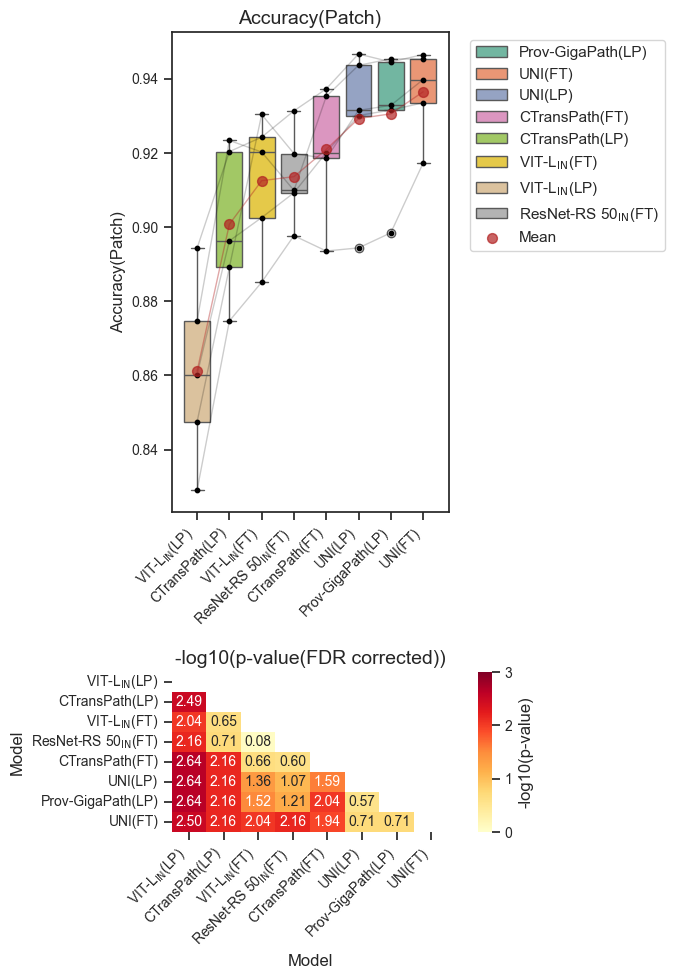

cv - fine - 500 - acc
saved out/figs/box_cv_fine_500_acc.png
cv - fine - 500 - f1
saved out/figs/box_cv_fine_500_f1.png
cv - coarse - 500 - pacc
saved out/figs/box_cv_coarse_500_pacc.png


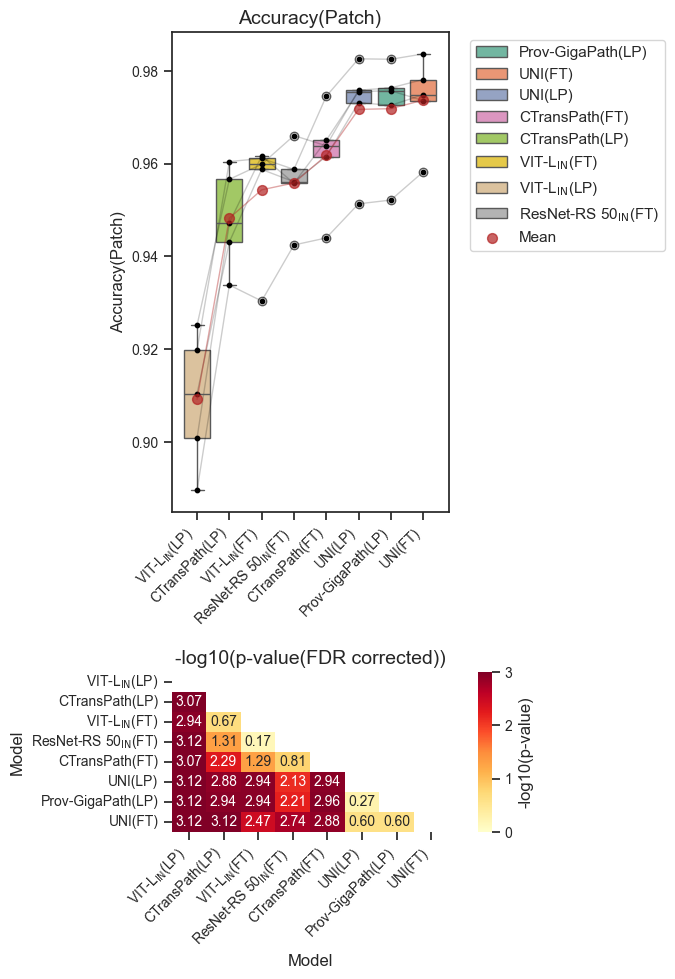

cv - coarse - 500 - acc
saved out/figs/box_cv_coarse_500_acc.png
cv - coarse - 500 - f1
saved out/figs/box_cv_coarse_500_f1.png


In [49]:
paired_box('cv', False, 500, 'pacc', True)
paired_box('cv', False, 500, 'acc')
paired_box('cv', False, 500, 'f1')

paired_box('cv', True, 500, 'pacc', True)
paired_box('cv', True, 500, 'acc')
paired_box('cv', True, 500, 'f1')

### EBRAINS 500 fine patches/case

ebrains - fine - 500 - acc
saved out/figs/box_cv_fine_500_acc.png


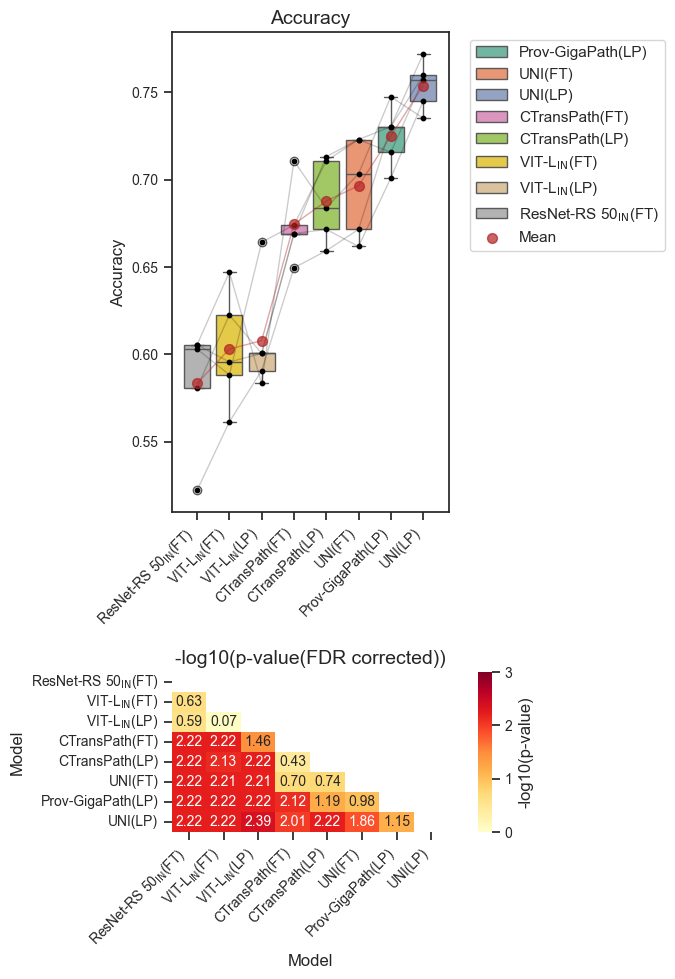

ebrains - fine - 500 - acc
saved out/figs/box_cv_fine_500_acc.png
ebrains - fine - 500 - f1
saved out/figs/box_cv_fine_500_f1.png
ebrains - coarse - 500 - pacc
saved out/figs/box_cv_coarse_500_pacc.png


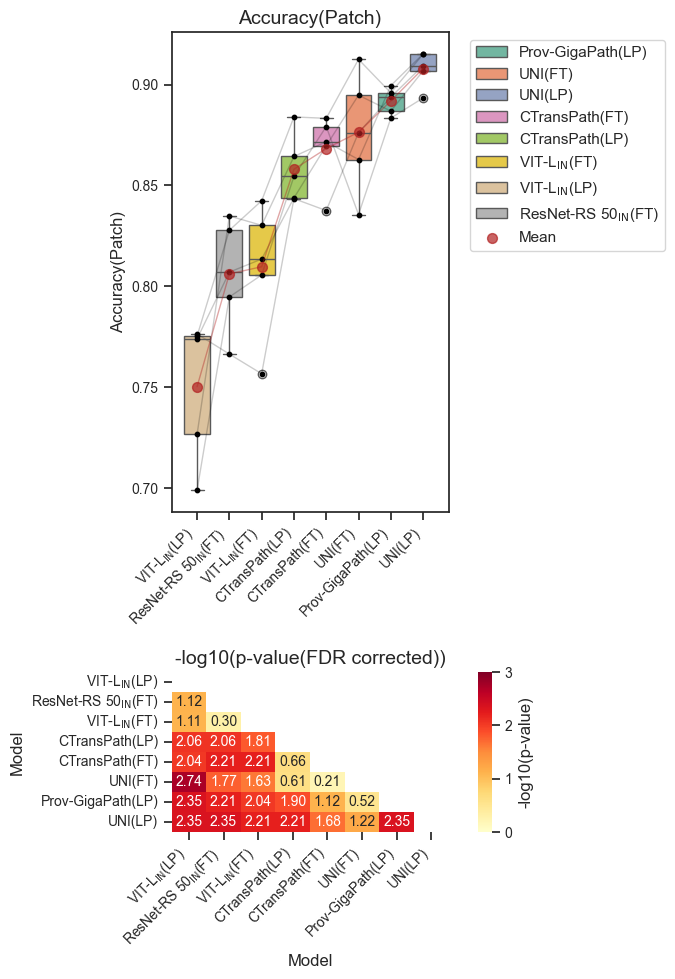

ebrains - coarse - 500 - acc
saved out/figs/box_cv_coarse_500_acc.png
ebrains - coarse - 500 - f1
saved out/figs/box_cv_coarse_500_f1.png


In [50]:
paired_box('ebrains', False, 500, 'acc', True)
paired_box('ebrains', False, 500, 'acc')
paired_box('ebrains', False, 500, 'f1')

paired_box('ebrains', True, 500, 'pacc',  True)
paired_box('ebrains', True, 500, 'acc')
paired_box('ebrains', True, 500, 'f1')

### EBRAINS coarse 100 patches/case

#### fig4

This fig shows the impact of patch number per case on model performace

In [62]:
labels = [
    'Prov-GigaPath(LP)',
    'UNI(FT)',
    'UNI(LP)',
    'CTransPath(FT)',
    'CTransPath(LP)',
    'VIT-L$\\mathrm{_{IN}}$(FT)',
    'VIT-L$\\mathrm{_{IN}}$(LP)',
    'ResNet-RS 50$\\mathrm{_{IN}}$(FT)',
    # 'ResNet-RS 50$\\mathrm{_{IN}}$(LP)',
]

def draw_lines(target:Literal['cv', 'ebrains'], key:str, coarse:bool, fill=False, show=False):
    label_order = [
        'Prov-GigaPath(LP)',
        'UNI(FT)',
        'UNI(LP)',
        'CTransPath(FT)',
        'CTransPath(LP)',
        r'VIT-L$\mathrm{_{IN}}$(FT)',
        r'VIT-L$\mathrm{_{IN}}$(LP)',
        r'ResNet-RS 50$\mathrm{_{IN}}$(FT)',
        # r'ResNet-RS 50$\mathrm{_{IN}}$(LP)',
    ]

    grains = 'coarse' if coarse else 'fine'
    key_label = {
        'pacc': 'Accuracy(Patch)',
        'acc': 'Accuracy',
        'f1': 'F1 score',
    }[key]
    
    color_map = dict(zip((label_order), plt.cm.Set2(np.linspace(0, 1, len(label_order)))))
    
    limits = [10, 25, 100, 500]
    alpha = 0.05
    
    values_by_limit = []

    for limit in limits:
        values = []
        df = pd.read_excel(f'out/figs/results_{grains}_{target}.xlsx', sheet_name=f'{limit}', index_col=0)

        # if labels is None:
        #     if limit == limits[0]:
        #         # sort on 10 limit
        #         df_mean = df.groupby('label')[key].mean().sort_values(ascending=True)
        #         df[f'average_{key}'] = df['label'].map(df_mean)
        #         df = df.sort_values([f'average_{key}', 'fold'], ascending=[True, True])
        #         labels = df['label'].unique()[::-1]

        for label in labels:
            scores = df[df['label']==label][key_label]
            mean = np.mean(scores)
            diff = stats.sem(scores)
            # CI
            # diff = stats.t.interval(1 - alpha, df=len(scores)-1, loc=mean, scale=diff)[1] - mean
            values.append([mean, mean-diff, mean+diff])
        values_by_limit.append(values)    
    values_by_cond = np.array(values_by_limit).transpose(1, 0, 2)
    
    plt.figure(figsize=(6, 7))
    x = np.arange(1, 1+len(limits))

    for i, label in enumerate(labels):
        ci_l = values_by_cond[i, :, 1]
        ci_h = values_by_cond[i, :, 2]
        # c = colors[i]
        c = color_map[label]
        plt.plot(x, values_by_cond[i, :, 0], color=c, label=label)
        if fill:
            plt.fill_between(x, ci_l, ci_h, color=c, alpha=0.1)
    
    plt.xticks(x, limits)
    plt.xlabel('Patch count per case')
    plt.ylabel(key_label)
    # plt.legend(loc='lower right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(key_label)    
    plt.tight_layout()
    fig_path = f'out/figs/plot_{target}_{grains}_{key}.png'
    plt.savefig(fig_path, format="png", dpi=DPI)
    print(f'wrote {fig_path}')
    if show:
        plt.show()
    else:
        plt.close()



wrote out/figs/plot_cv_fine_pacc.png


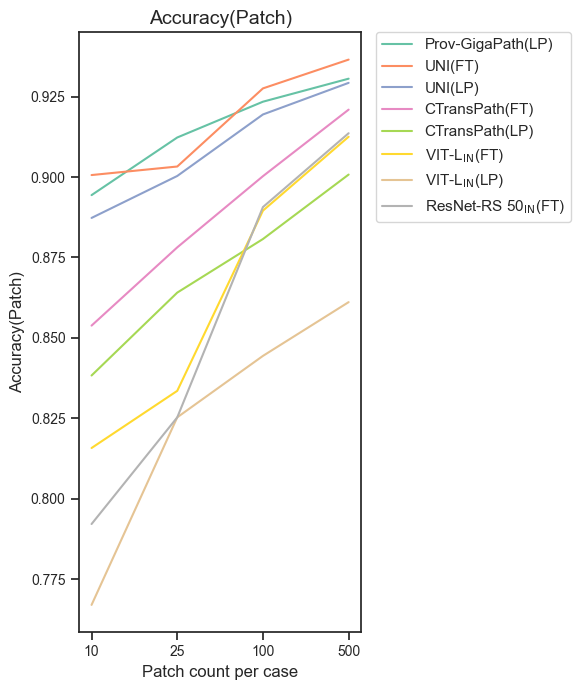

wrote out/figs/plot_cv_fine_acc.png


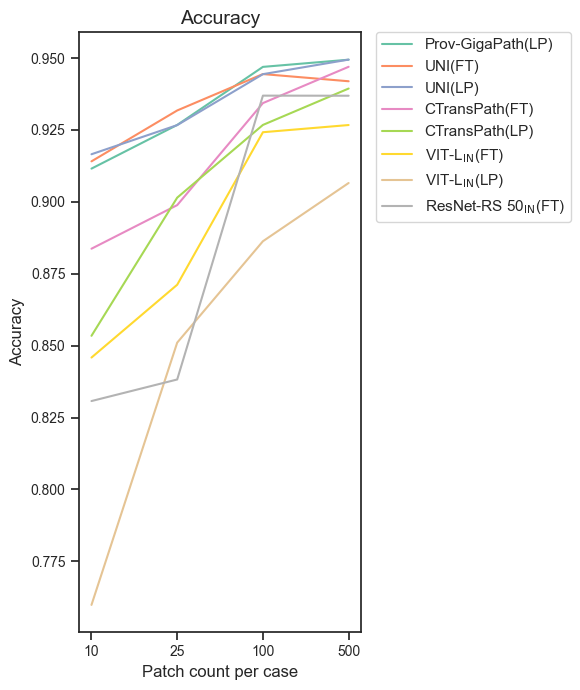

wrote out/figs/plot_cv_fine_f1.png
wrote out/figs/plot_cv_coarse_pacc.png


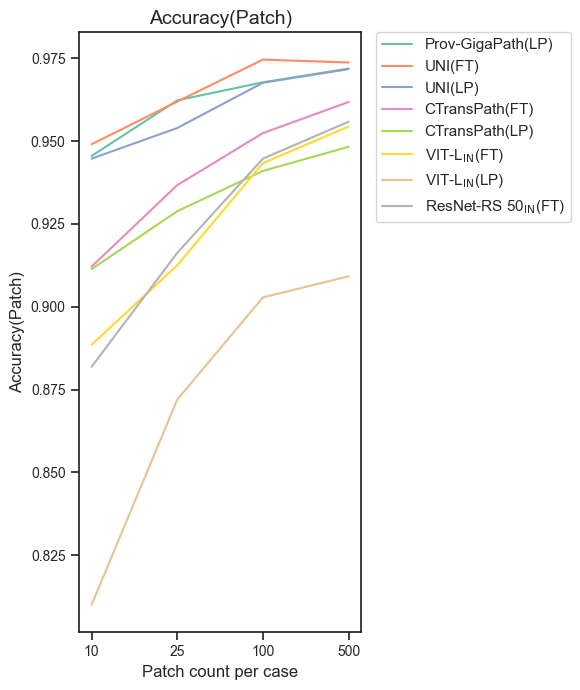

wrote out/figs/plot_cv_coarse_acc.png


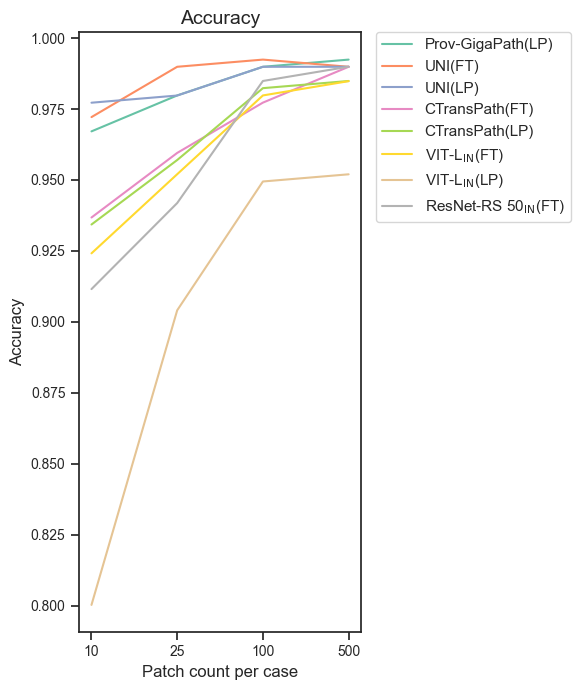

wrote out/figs/plot_cv_coarse_f1.png


In [65]:
draw_lines('cv', 'pacc', False, show=True)
draw_lines('cv', 'acc', False, show=True)
draw_lines('cv', 'f1', False)

draw_lines('cv', 'pacc', True, show=True)
draw_lines('cv', 'acc', True, show=True)
draw_lines('cv', 'f1', True)

### Fig4: EBRAINS - lines

wrote out/figs/plot_ebrains_fine_pacc.png


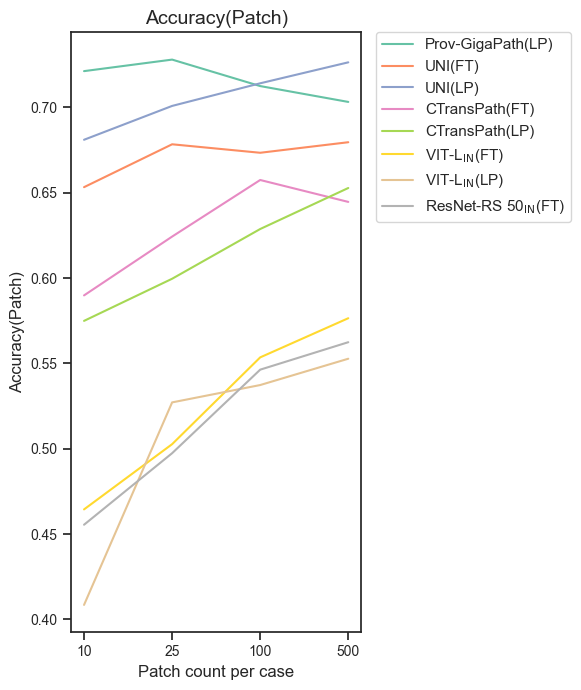

wrote out/figs/plot_ebrains_fine_acc.png


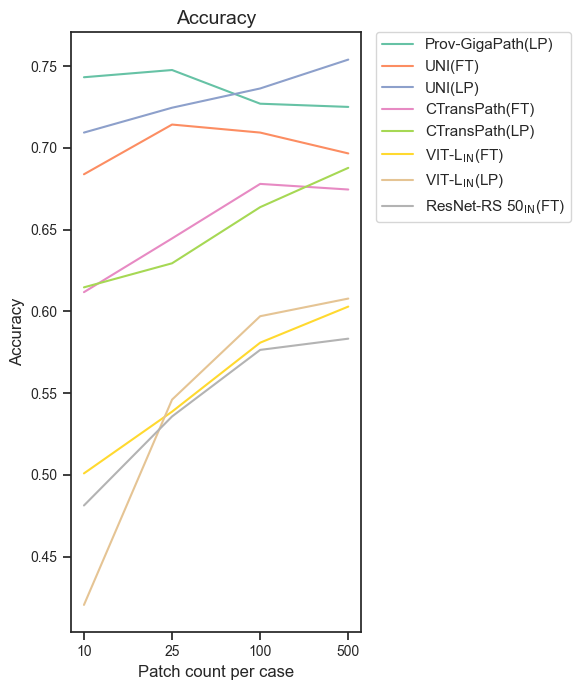

wrote out/figs/plot_ebrains_fine_f1.png
wrote out/figs/plot_ebrains_coarse_pacc.png


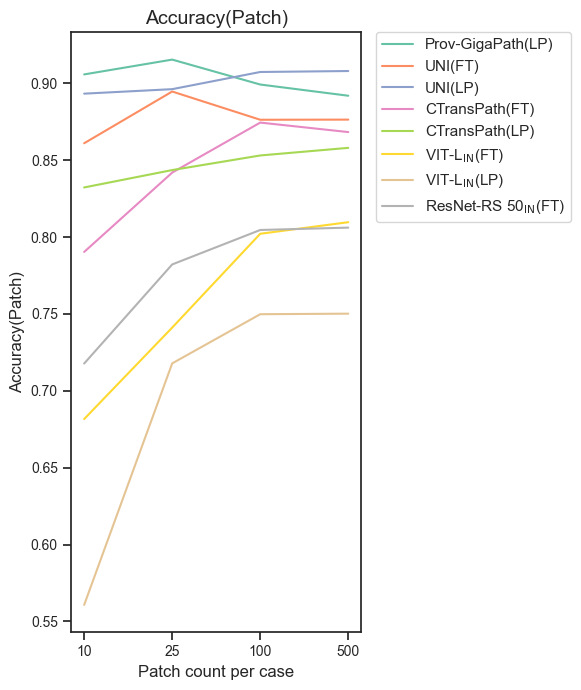

wrote out/figs/plot_ebrains_coarse_acc.png


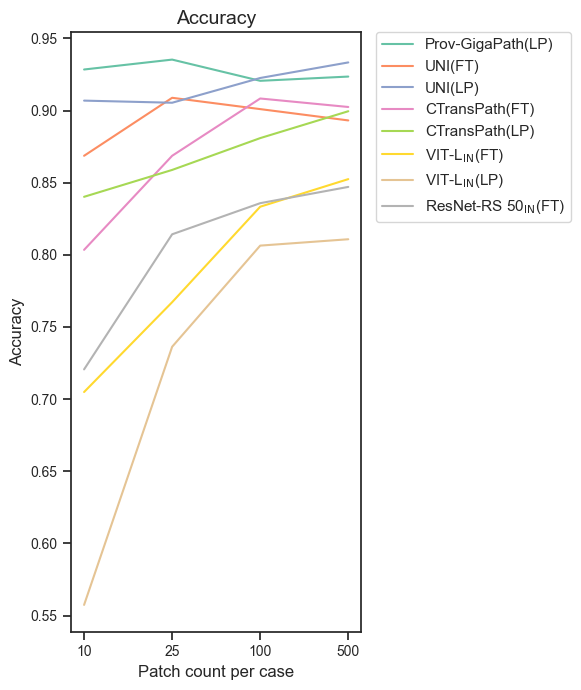

wrote out/figs/plot_ebrains_coarse_f1.png


In [66]:
draw_lines('ebrains', 'pacc', False, show=True)
draw_lines('ebrains', 'acc', False, show=True)
draw_lines('ebrains', 'f1', False)

draw_lines('ebrains', 'pacc', True, show=True)
draw_lines('ebrains', 'acc', True, show=True)
draw_lines('ebrains', 'f1', True)